## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

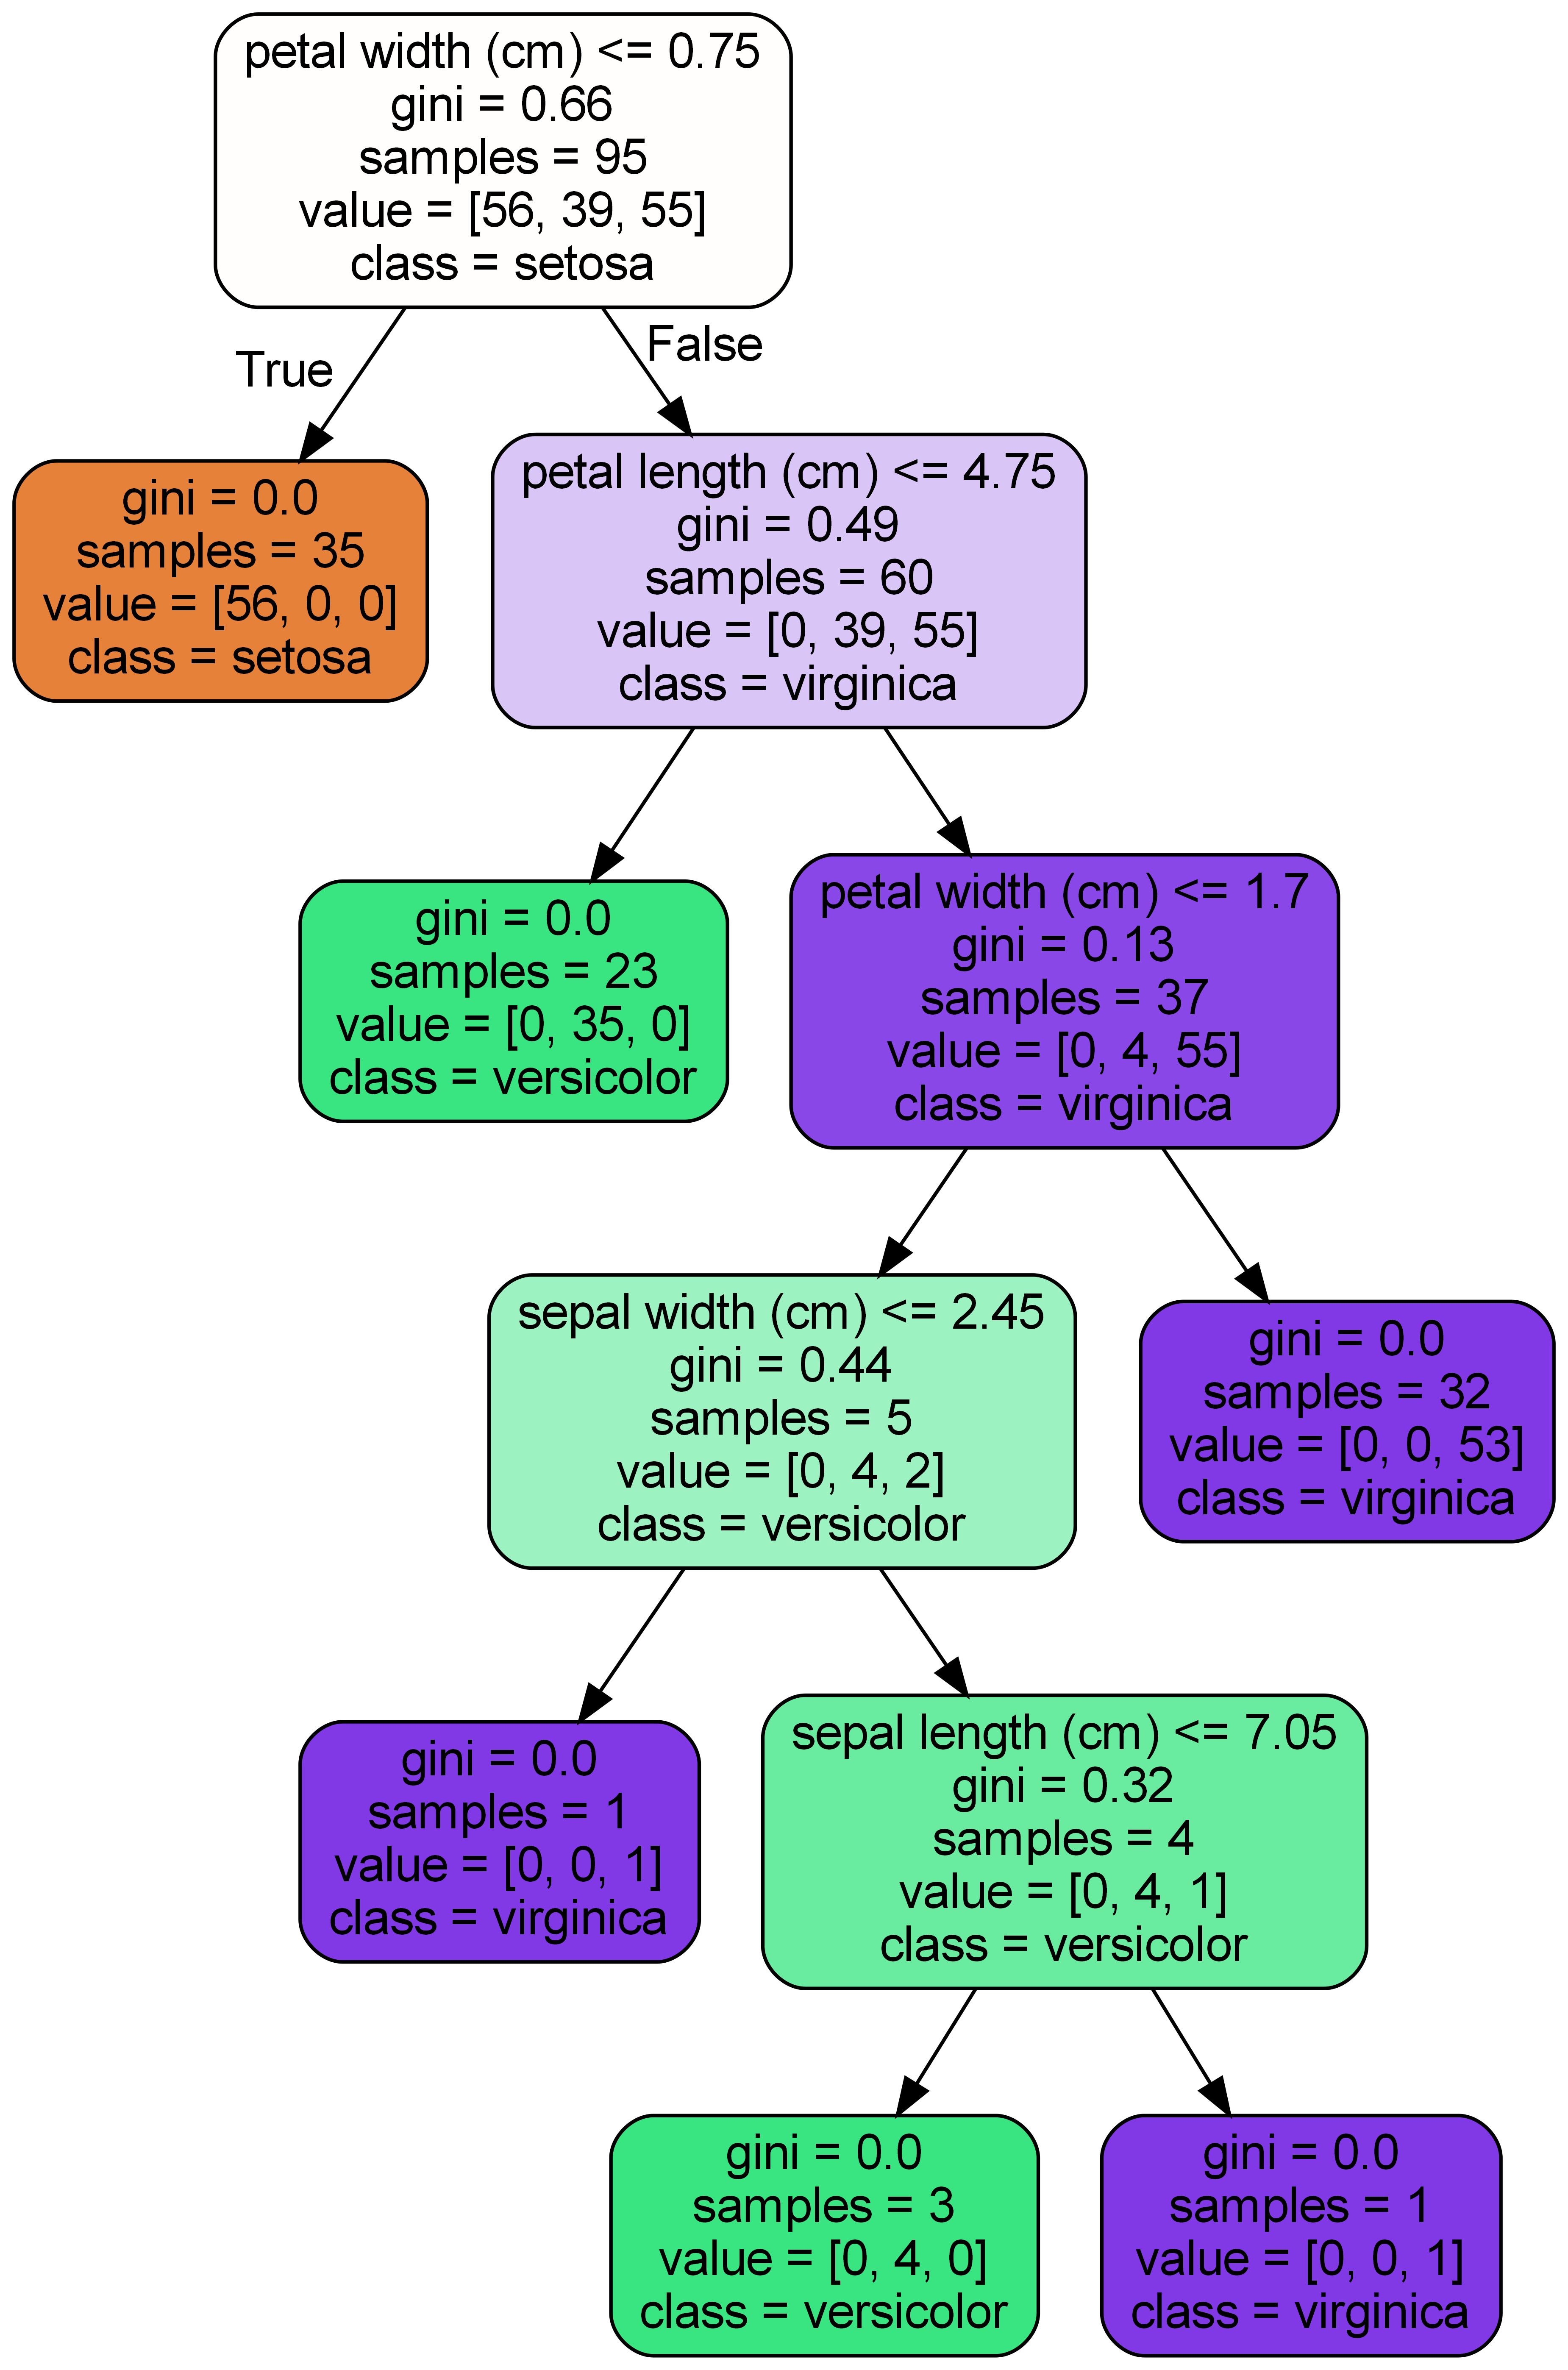

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [2]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [3]:
url ='SouthKoreacoronavirusdataset/PatientInfo.csv'
df = pd.read_csv(url)
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [4]:
df.shape

(2218, 18)

In [5]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [6]:
#counts of response variable values
df.state.value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [7]:
df['n_age']=2020-df['birth_year']
df['n_age']

0       56.0
1       33.0
2       56.0
3       29.0
4       28.0
        ... 
2213    30.0
2214    22.0
2215    22.0
2216    48.0
2217    46.0
Name: n_age, Length: 2218, dtype: float64

### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [8]:
df.isnull().sum()

patient_id               0
global_num             904
sex                    145
birth_year             454
age                    261
country                  0
province                 0
city                    65
disease               2199
infection_case        1055
infection_order       2176
infected_by           1749
contact_number        1807
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                  454
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             19 non-null     object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [10]:
df["disease"] = df["disease"].fillna(0)
df["disease"] = df["disease"].replace(True,1)
df["disease"].unique()

array([0, 1], dtype=int64)

 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [11]:
df['global_num'].fillna(df['global_num'].mean(), inplace=True)
df['birth_year'].fillna(df['birth_year'].mean(), inplace=True)
df['infection_order'].fillna(df['infection_order'].mean(), inplace=True)
df['infected_by'].fillna(df['infected_by'].mean(), inplace=True)
df['contact_number'].fillna(df['contact_number'].mean(), inplace=True)

 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

In [12]:
df.isnull().sum()

patient_id               0
global_num               0
sex                    145
birth_year               0
age                    261
country                  0
province                 0
city                    65
disease                  0
infection_case        1055
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                  454
dtype: int64

In [13]:
# Let's make this match birth year data.
df['n_age']=2020-df['birth_year']
# Let's take the above data to fill in age decade. 
df['age'].fillna(df['n_age'].apply(lambda x: str(x//10)+'0s'), inplace=True)
df.isnull().sum()

patient_id               0
global_num               0
sex                    145
birth_year               0
age                      0
country                  0
province                 0
city                    65
disease                  0
infection_case        1055
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                    0
dtype: int64

In [14]:
for column in ['sex']:
    df.loc[df[column].isnull(), column] = df.loc[df[column].isnull(), column]\
    .apply(lambda x: df.loc[df[column].notnull(), column].sample().iloc[0])

In [15]:
df["sex_male"] = df["sex"].replace("male",1).replace("female",0)
df["sex_male"].value_counts()

0    1256
1     962
Name: sex_male, dtype: int64

In [16]:
df = df.drop('sex', axis=1)
df.head()

,patient_id,global_num,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age,sex_male
0,1000000001,2.0,1964.0,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,2.600789e+09,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,56.0,1
1,1000000002,5.0,1987.0,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,2.600789e+09,31.0,NaN,2020-01-30,2020-03-02,NaN,released,33.0,1
2,1000000003,6.0,1964.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,56.0,1
3,1000000004,7.0,1991.0,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,2.600789e+09,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,29.0,1
4,1000000005,9.0,1992.0,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,28.0,0


In [17]:
df.isnull().sum()

patient_id               0
global_num               0
birth_year               0
age                      0
country                  0
province                 0
city                    65
disease                  0
infection_case        1055
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                    0
sex_male                 0
dtype: int64

In [18]:
city_na = df.loc[df['city'].isna(), ['country', 'province', 'city']]
print(city_na.head(50))

    country province city
288   China    Busan  NaN
383   Korea    Daegu  NaN
394   Korea    Daegu  NaN
395   Korea    Daegu  NaN
396   Korea    Daegu  NaN
397   Korea    Daegu  NaN
398   Korea    Daegu  NaN
399   Korea    Daegu  NaN
406   Korea    Daegu  NaN
407   Korea    Daegu  NaN
408   Korea    Daegu  NaN
409   Korea    Daegu  NaN
410   Korea    Daegu  NaN
411   Korea    Daegu  NaN
412   Korea    Daegu  NaN
413   Korea    Daegu  NaN
414   Korea    Daegu  NaN
415   Korea    Daegu  NaN
416   Korea    Daegu  NaN
417   Korea    Daegu  NaN
418   Korea    Daegu  NaN
419   Korea    Daegu  NaN
420   Korea    Daegu  NaN
426   Korea    Daegu  NaN
427   Korea    Daegu  NaN
428   Korea    Daegu  NaN
429   Korea    Daegu  NaN
430   Korea    Daegu  NaN
431   Korea    Daegu  NaN
432   Korea    Daegu  NaN
433   Korea    Daegu  NaN
434   Korea    Daegu  NaN
435   Korea    Daegu  NaN
436   Korea    Daegu  NaN
437   Korea    Daegu  NaN
438   Korea    Daegu  NaN
439   Korea    Daegu  NaN
440   Korea 

In [19]:
daegu_cities = df.loc[df['province'] == 'Daegu', 'city']
daegu_cities.unique()


array([nan, 'Jung-gu', 'Nam-gu', 'Dalseo-gu', 'Dalseong-gun', 'Seo-gu',
       'Suseong-gu', 'Dong-gu'], dtype=object)

In [20]:
for column in ['city']:
    boolean_series = (df[column].isnull()) & (df['province'] == 'Daegu')
    subset = df.loc[boolean_series, column]
    subset = subset.apply(lambda x: df.loc[(df[column].notnull()) & (df['province'] == 'Daegu'), column].sample().iloc[0])
    df.loc[boolean_series, column] = subset

In [21]:
city_na = df.loc[df['city'].isna(), ['country', 'province', 'city']]
print(city_na.head(50))

     country          province city
288    China             Busan  NaN
446    Korea           Gwangju  NaN
447    Korea           Gwangju  NaN
448    Korea           Gwangju  NaN
449    Korea           Gwangju  NaN
450    Korea           Gwangju  NaN
451    Korea           Gwangju  NaN
452    Korea           Gwangju  NaN
453    Korea           Gwangju  NaN
454    Korea           Gwangju  NaN
455    Korea           Gwangju  NaN
456    Korea           Gwangju  NaN
457    Korea           Gwangju  NaN
458    Korea           Gwangju  NaN
459    Korea           Gwangju  NaN
460    Korea           Gwangju  NaN
461    Korea           Gwangju  NaN
462    Korea           Gwangju  NaN
463    Korea           Gwangju  NaN
1071   Korea      Jeollanam-do  NaN
2159   Korea  Gyeongsangnam-do  NaN
2160   Korea  Gyeongsangnam-do  NaN
2161   Korea  Gyeongsangnam-do  NaN


In [22]:
gwangju_cities = df.loc[df['province'] == 'Gwangju', 'city']
gwangju_cities.unique()

array([nan], dtype=object)

In [23]:
for column in ['city']:
    boolean_series = (df[column].isnull()) & (df['province'] == 'Gwangju')
    subset = df.loc[boolean_series, column]
    subset = subset.apply(lambda x: np.random.choice(['Buk', 'Dong', 'Gwangsan', 'Nam', 'Seo']))
    df.loc[boolean_series, column] = subset
gwangju_cities = df.loc[df['province'] == 'Gwangju', 'city']
gwangju_cities.unique()




array(['Nam', 'Gwangsan', 'Buk', 'Seo', 'Dong'], dtype=object)

In [24]:
city_na = df.loc[df['city'].isna(), ['country', 'province', 'city']]
print(city_na.head(50))

     country          province city
288    China             Busan  NaN
1071   Korea      Jeollanam-do  NaN
2159   Korea  Gyeongsangnam-do  NaN
2160   Korea  Gyeongsangnam-do  NaN
2161   Korea  Gyeongsangnam-do  NaN


In [25]:
jeollanam_do_cities = df.loc[df['province'] == 'Jeollanam-do', 'city']
jeollanam_do_cities.unique()

array([nan, 'Suncheon-si', 'Yeosu-si', 'Gwangyang-si'], dtype=object)

In [26]:
for column in ['city']:
    boolean_series = (df[column].isnull()) & (df['province'] == 'Jeollanam-do')
    subset = df.loc[boolean_series, column]
    subset = subset.apply(lambda x: np.random.choice(['Suncheon-si', 'Yeosu-si', 'Gwangyang-si']))
    df.loc[boolean_series, column] = subset
    
jeollanam_do_cities = df.loc[df['province'] == 'Jeollanam-do', 'city']
jeollanam_do_cities.unique()

array(['Yeosu-si', 'Suncheon-si', 'Gwangyang-si'], dtype=object)

In [27]:
gyeongsangnam_do_cities = df.loc[df['province'] == 'Gyeongsangnam-do', 'city']
gyeongsangnam_do_cities.unique()

array(['Hapcheon-gun', 'Jinju-si', 'Changwon-si', 'Yangsan-si',
       'Geoje-si', 'Hamyang-gun', 'Goseong-gun', 'Gimhae-si',
       'Namhae-gun', nan, 'Geochang-gun', 'Changnyeong-gun', 'Miryang-si'],
      dtype=object)

In [28]:
for column in ['city']:
    boolean_series = (df[column].isnull()) & (df['province'] == 'Gyeongsangnam-do')
    subset = df.loc[boolean_series, column]
    subset = subset.apply(lambda x: np.random.choice(['Hapcheon-gun', 'Jinju-si', 'Changwon-si', 'Yangsan-si',
       'Geoje-si', 'Hamyang-gun', 'Goseong-gun', 'Gimhae-si',
       'Namhae-gun', 'Geochang-gun', 'Changnyeong-gun', 'Miryang-si']))
    df.loc[boolean_series, column] = subset

gyeongsangnam_do_cities = df.loc[df['province'] == 'Gyeongsangnam-do', 'city']
gyeongsangnam_do_cities.unique()


array(['Hapcheon-gun', 'Jinju-si', 'Changwon-si', 'Yangsan-si',
       'Geoje-si', 'Hamyang-gun', 'Goseong-gun', 'Gimhae-si',
       'Namhae-gun', 'Geochang-gun', 'Changnyeong-gun', 'Miryang-si'],
      dtype=object)

In [29]:
city_na = df.loc[df['city'].isna(), ['country', 'province', 'city']]
print(city_na.head(50))

    country province city
288   China    Busan  NaN


In [30]:
# Filling in the last remaing "city" = "NaN" which is Busan's city (district) with the most populous
df['city'] = df['city'].fillna("Haeundae")
city_na = df.loc[df['city'].isna(), ['country', 'province', 'city']]
print(city_na.head(50))

Empty DataFrame
Columns: [country, province, city]
Index: []


In [31]:
df['city'].unique()

array(['Gangseo-gu', 'Jungnang-gu', 'Jongno-gu', 'Mapo-gu', 'Seongbuk-gu',
       'etc', 'Songpa-gu', 'Seodaemun-gu', 'Seongdong-gu', 'Seocho-gu',
       'Guro-gu', 'Gangdong-gu', 'Eunpyeong-gu', 'Geumcheon-gu',
       'Gwanak-gu', 'Nowon-gu', 'Dongjak-gu', 'Gangnam-gu',
       'Yangcheon-gu', 'Gwangjin-gu', 'Dongdaemun-gu', 'Yeongdeungpo-gu',
       'Dobong-gu', 'Yongsan-gu', 'Gangbuk-gu', 'Jung-gu', 'Dongnae-gu',
       'Haeundae-gu', 'Yeonje-gu', 'Haeundae', 'Buk-gu', 'Nam-gu',
       'Seo-gu', 'Geumjeong-gu', 'Saha-gu', 'Suyeong-gu', 'Sasang-gu',
       'Busanjin-gu', 'Dalseo-gu', 'Dalseong-gun', 'Dong-gu',
       'Suseong-gu', 'Nam', 'Gwangsan', 'Buk', 'Seo', 'Dong', 'Wuhan',
       'Bupyeong-gu', 'Michuhol-gu', 'Yeonsu-gu', 'Gyeyang-gu',
       'Namdong-gu', 'Yuseong-gu', 'Daedeok-gu', 'Ulju-gun', 'Sejong',
       'Goyang-si', 'Pyeongtaek-si', 'Bucheon-si', 'Suwon-si', 'Guri-si',
       'Siheung-si', 'Gimpo-si', 'Icheon-si', 'Pocheon-si', 'Anyang-si',
       'Yongin-si', 'Paju-si

In [32]:
df.loc[(df['city'] == 'Wuhan') | (df['city'] == 'etc')]


,patient_id,global_num,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age,sex_male
7,1000000008,13.000000,1992.0,20s,Korea,Seoul,etc,0,overseas inflow,1.000000,2.600789e+09,0.000000,NaN,2020-02-02,2020-02-24,NaN,released,28.0,1
11,1000000012,24.000000,1992.0,20s,Korea,Seoul,etc,0,overseas inflow,1.000000,2.600789e+09,0.000000,NaN,2020-02-07,2020-02-27,NaN,released,28.0,1
17,1000000018,111.000000,2000.0,20s,Korea,Seoul,etc,0,etc,2.285714,2.600789e+09,24.128954,NaN,2020-02-20,NaN,NaN,isolated,20.0,1
34,1000000035,847.000000,1984.0,30s,Korea,Seoul,etc,0,etc,2.285714,2.600789e+09,24.128954,2020-02-19,2020-02-25,NaN,NaN,isolated,36.0,1
37,1000000038,907.000000,1953.0,60s,Korea,Seoul,etc,0,etc,2.285714,2.600789e+09,24.128954,2020-02-24,2020-02-25,NaN,NaN,isolated,67.0,1
45,1000000046,1246.000000,1999.0,20s,Korea,Seoul,etc,0,contact with patient,2.285714,1.000000e+09,24.128954,NaN,2020-02-26,2020-03-03,NaN,released,21.0,0
55,1000000056,1611.000000,1962.0,50s,Korea,Seoul,etc,0,etc,2.285714,2.600789e+09,24.128954,NaN,2020-02-27,2020-03-13,NaN,released,58.0,1
56,1000000057,1675.000000,1946.0,70s,Korea,Seoul,etc,0,Eunpyeong St. Mary's Hospital,2.285714,2.600789e+09,24.128954,NaN,2020-02-27,NaN,NaN,released,74.0,0
72,1000000073,2840.000000,1975.0,40s,Korea,Seoul,etc,0,etc,2.285714,2.600789e+09,24.128954,2020-02-25,2020-02-27,NaN,NaN,isolated,45.0,1
106,1000000107,6589.000000,1985.0,30s,Korea,Seoul,etc,0,contact with patient,2.285714,2.600789e+09,24.128954,NaN,2020-03-06,NaN,NaN,isolated,35.0,1


In [33]:
df.loc[(df['province'] == 'Seoul')]

,patient_id,global_num,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age,sex_male
0,1000000001,2.0,1964.0,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.000000,2.600789e+09,75.000000,2020-01-22,2020-01-23,2020-02-05,NaN,released,56.0,1
1,1000000002,5.0,1987.0,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.000000,2.600789e+09,31.000000,NaN,2020-01-30,2020-03-02,NaN,released,33.0,1
2,1000000003,6.0,1964.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,2.000000,2.002000e+09,17.000000,NaN,2020-01-30,2020-02-19,NaN,released,56.0,1
3,1000000004,7.0,1991.0,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,1.000000,2.600789e+09,9.000000,2020-01-26,2020-01-30,2020-02-15,NaN,released,29.0,1
4,1000000005,9.0,1992.0,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.000000,1.000000e+09,2.000000,NaN,2020-01-31,2020-02-24,NaN,released,28.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,1000000278,8476.0,1994.0,20s,Korea,Seoul,Nowon-gu,0,overseas inflow,2.285714,2.600789e+09,24.128954,2020-03-15,2020-03-18,NaN,NaN,isolated,26.0,0
278,1000000279,8476.0,1929.0,90s,Korea,Seoul,Yongsan-gu,0,etc,2.285714,2.600789e+09,24.128954,NaN,2020-03-18,NaN,NaN,isolated,91.0,1
279,1000000280,8547.0,1977.0,40s,Korea,Seoul,Gangnam-gu,0,etc,2.285714,2.600789e+09,24.128954,NaN,2020-03-18,NaN,NaN,isolated,43.0,1
280,1000000281,8456.0,1982.0,30s,Korea,Seoul,Dongjak-gu,0,overseas inflow,2.285714,2.600789e+09,24.128954,NaN,2020-03-18,NaN,NaN,isolated,38.0,0


In [34]:
df['country'].value_counts()

Korea       2206
China         10
Mongolia       1
Thailand       1
Name: country, dtype: int64

In [35]:
df.loc[(df['country'] == 'Thailand') | (df['country'] == 'China') | (df['country'] == 'Mongolia')]


,patient_id,global_num,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age,sex_male
10,1000000011,23.000000,1962.000000,50s,China,Seoul,Seodaemun-gu,0,overseas inflow,1.000000,2.600789e+09,23.000000,NaN,2020-02-06,2020-02-29,NaN,released,58.000000,0
29,1000000030,755.000000,1954.000000,60s,China,Seoul,Gangdong-gu,0,Eunpyeong St. Mary's Hospital,2.285714,2.600789e+09,24.128954,NaN,2020-02-23,NaN,NaN,released,66.000000,1
38,1000000039,924.000000,1945.000000,70s,China,Seoul,Geumcheon-gu,0,overseas inflow,2.285714,2.600789e+09,24.128954,NaN,2020-02-25,NaN,NaN,released,75.000000,0
288,1100000007,4664.816591,1994.000000,20s,China,Busan,Haeundae,0,Shincheonji Church,2.285714,2.600789e+09,485.000000,NaN,2020-02-22,NaN,NaN,isolated,26.000000,1
464,1400000001,1.000000,1985.000000,30s,China,Incheon,Wuhan,0,overseas inflow,2.285714,2.600789e+09,24.128954,2020-01-19,2020-01-20,2020-02-06,NaN,released,35.000000,0
591,2000000003,12.000000,1971.000000,40s,China,Gyeonggi-do,Bucheon-si,0,contact with patient,2.000000,2.600789e+09,422.000000,NaN,2020-02-01,2020-02-18,NaN,released,49.000000,1
592,2000000004,14.000000,1980.000000,40s,China,Gyeonggi-do,Goyang-si,0,contact with patient,3.000000,2.000000e+09,3.000000,NaN,2020-02-02,2020-02-18,NaN,released,40.000000,0
598,2000000010,27.000000,1982.000000,30s,China,Gyeonggi-do,Siheung-si,0,overseas inflow,1.000000,2.600789e+09,40.000000,NaN,2020-02-09,NaN,NaN,isolated,38.000000,0
599,2000000011,28.000000,1989.000000,30s,China,Gyeonggi-do,Goyang-si,0,contact with patient,2.000000,2.000000e+09,1.000000,NaN,2020-02-10,2020-02-17,NaN,released,31.000000,0
627,2000000039,875.000000,1984.000000,30s,Mongolia,Gyeonggi-do,Namyangju-si,1,etc,2.285714,2.600789e+09,24.128954,NaN,2020-02-25,NaN,2020-02-25,deceased,36.000000,1


In [36]:
seoul_cities = df.loc[df['province'] == 'Seoul', 'city']
seoul_cities.value_counts()

Dongdaemun-gu      25
Guro-gu            22
etc                18
Eunpyeong-gu       18
Gwanak-gu          17
Gangnam-gu         16
Nowon-gu           16
Songpa-gu          16
Yangcheon-gu       15
Gangseo-gu         15
Yeongdeungpo-gu    13
Seongbuk-gu        11
Jongno-gu          11
Mapo-gu            10
Dongjak-gu          9
Seocho-gu           9
Seodaemun-gu        8
Gangbuk-gu          5
Geumcheon-gu        5
Jungnang-gu         5
Gangdong-gu         5
Yongsan-gu          4
Gwangjin-gu         3
Seongdong-gu        3
Dobong-gu           2
Jung-gu             1
Name: city, dtype: int64

In [37]:
# Replacing "etc" cities (districts) in the Seoul province for a proportional random sample of other cities in Seoul

for column in ['city']:
    boolean_series = (df['city'] == 'etc') & (df['province'] == 'Seoul')
    subset = df.loc[boolean_series, column]
    subset = subset.apply(lambda x: df.loc[(df['city'] != 'etc') & (df['province'] == 'Seoul'), column].sample().iloc[0])
    df.loc[boolean_series, column] = subset

seoul_cities = df.loc[df['province'] == 'Seoul', 'city']
seoul_cities.value_counts()

Dongdaemun-gu      26
Guro-gu            25
Gwanak-gu          19
Nowon-gu           18
Eunpyeong-gu       18
Yangcheon-gu       17
Gangnam-gu         16
Songpa-gu          16
Gangseo-gu         15
Seongbuk-gu        14
Yeongdeungpo-gu    14
Jongno-gu          12
Dongjak-gu         10
Mapo-gu            10
Seocho-gu           9
Seodaemun-gu        9
Geumcheon-gu        6
Gangdong-gu         5
Jungnang-gu         5
Gangbuk-gu          5
Yongsan-gu          4
Seongdong-gu        3
Gwangjin-gu         3
Dobong-gu           2
Jung-gu             1
Name: city, dtype: int64

In [38]:
# Replacing "etc" cities (districts) in the Busan province for a proportional random sample of other cities in Seoul

for column in ['city']:
    boolean_series = (df['city'] == 'etc') & (df['province'] == 'Busan')
    subset = df.loc[boolean_series, column]
    subset = subset.apply(lambda x: df.loc[(df['city'] != 'etc') & (df['province'] == 'Busan'), column].sample().iloc[0])
    df.loc[boolean_series, column] = subset

busan_cities = df.loc[df['province'] == 'Busan', 'city']
busan_cities.value_counts()

Dongnae-gu      31
Haeundae-gu     17
Busanjin-gu     12
Saha-gu          8
Suyeong-gu       8
Seo-gu           6
Yeonje-gu        4
Geumjeong-gu     4
Buk-gu           3
Gangseo-gu       3
Nam-gu           2
Sasang-gu        2
Haeundae         1
Name: city, dtype: int64

In [39]:
# Replacing "etc" cities in the Jeollabuk-do province for a proportional random sample of other cities in Seoul

for column in ['city']:
    boolean_series = (df['city'] == 'etc') & (df['province'] == 'Jeollabuk-do')
    subset = df.loc[boolean_series, column]
    subset = subset.apply(lambda x: df.loc[(df['city'] != 'etc') & (df['province'] == 'Jeollabuk-do'), column].sample().iloc[0])
    df.loc[boolean_series, column] = subset

jeollabuk_do_cities = df.loc[df['province'] == 'Jeollabuk-do', 'city']
jeollabuk_do_cities.value_counts()

Jeonju-si    5
Gunsan-si    1
Gimje-si     1
Name: city, dtype: int64

In [40]:
# Replacing "etc" cities in the Jeju-do province for a proportional random sample of other cities in Seoul

for column in ['city']:
    boolean_series = (df['city'] == 'etc') & (df['province'] == 'Jeju-do')
    subset = df.loc[boolean_series, column]
    subset = subset.apply(lambda x: df.loc[(df['city'] != 'etc') & (df['province'] == 'Jeju-do'), column].sample().iloc[0])
    df.loc[boolean_series, column] = subset

jeju_do_cities = df.loc[df['province'] == 'Jeju-do', 'city']
jeju_do_cities.value_counts()

Jeju-do    4
Name: city, dtype: int64

In [41]:
# Replacing "Wuhan" city (districts) in the Incheon province for a proportional random sample of other cities in Seoul

for column in ['city']:
    boolean_series = (df['city'] == 'Wuhan') & (df['province'] == 'Incheon')
    subset = df.loc[boolean_series, column]
    subset = subset.apply(lambda x: df.loc[(df['city'] != 'Wuhan') & (df['province'] == 'Incheon'), column].sample().iloc[0])
    df.loc[boolean_series, column] = subset

incheon_cities = df.loc[df['province'] == 'Incheon', 'city']
incheon_cities.value_counts()

Bupyeong-gu    8
Michuhol-gu    7
Namdong-gu     6
Yeonsu-gu      5
Seo-gu         3
Gyeyang-gu     3
Name: city, dtype: int64

In [42]:
# Looks like we need to make all foreign countries be South Korea. 
# Two reasons behind that: 
    # 1) This data is about South Korea and 
    # 2) They mostly have South Korean cities and provinces. 

In [43]:
df['country'] = df['country'].replace('China', 'Korea').replace('Mongolia', 'Korea').replace('Thailand', 'Korea')
df['country'].unique()

array(['Korea'], dtype=object)

In [44]:
df.isnull().sum()

patient_id               0
global_num               0
birth_year               0
age                      0
country                  0
province                 0
city                     0
disease                  0
infection_case        1055
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                    0
sex_male                 0
dtype: int64

In [45]:
df['infection_case'].value_counts()

contact with patient                530
etc                                 220
Guro-gu Call Center                 102
Shincheonji Church                   86
overseas inflow                      61
Onchun Church                        33
gym facility in Cheonan              30
Ministry of Oceans and Fisheries     27
Cheongdo Daenam Hospital             21
Dongan Church                        17
Eunpyeong St. Mary's Hospital        14
Seongdong-gu APT                     13
gym facility in Sejong                4
Suyeong-gu Kindergarten               3
River of Grace Community Church       1
Pilgrimage to Israel                  1
Name: infection_case, dtype: int64

Looking at the above data, it seems that we can put these into buckets. For example, we can package together, all of the gyms, churches, hospitals, Overseas Travel. There will be a few, like Guro-gu Call center, Ministry of Oceans and Fisheries, and Seondong-gu APT where we don't truly have buckets for them. After that, we can update NaN values and etc to be a proportional random sample of  existing cases. 

In [46]:
# find all churches that and replace with "Church"

df['infection_case'] = df['infection_case'].replace('Cheongdo Daenam Hospital', 'Church')\
                                            .replace('Onchun Church', 'Church')\
                                            .replace('Dongan Church', 'Church')\
                                            .replace('River of Grace Community Church', 'Church') 


In [47]:
# find all hospitals and replace with "Hospital"

df['infection_case'] = df['infection_case'].replace('Shincheonji Church', 'Hospital')\
                                            .replace("Eunpyeong St. Mary's Hospital", 'Hospital') 

In [48]:
# find all gyms and replace with "Gym"
df['infection_case'] = df['infection_case'].replace('gym facility in Sejong', 'Gym')\
                                            .replace("gym facility in Cheonan", 'Gym') 


In [49]:
# find all overseas travel and replace with "Overseas Travel"
df['infection_case'] = df['infection_case'].replace('Pilgrimage to Israel', 'Overseas Travel')\
                                            .replace("overseas inflow", 'Overseas Travel') 

In [50]:
df['infection_case'].value_counts()

contact with patient                530
etc                                 220
Guro-gu Call Center                 102
Hospital                            100
Church                               72
Overseas Travel                      62
Gym                                  34
Ministry of Oceans and Fisheries     27
Seongdong-gu APT                     13
Suyeong-gu Kindergarten               3
Name: infection_case, dtype: int64

In [51]:
# Find all NaN and "etc" values and proportionally replace them from a random sample of other values in the colum
df["infection_case"] = df["infection_case"].replace("etc", np.nan)
for column in ['infection_case']:
    df.loc[df[column].isnull(), column] = df.loc[df[column].isnull(), column]\
    .apply(lambda x: df.loc[df[column].notnull(), column].sample().iloc[0])



In [52]:
df['infection_case'].unique()

array(['Overseas Travel', 'contact with patient', 'Seongdong-gu APT',
       'Hospital', 'Guro-gu Call Center', 'Gym', 'Church',
       'Suyeong-gu Kindergarten', 'Ministry of Oceans and Fisheries'],
      dtype=object)

In [53]:
df['infection_case'].value_counts()

contact with patient                1233
Guro-gu Call Center                  255
Hospital                             241
Church                               166
Overseas Travel                      143
Gym                                   74
Ministry of Oceans and Fisheries      70
Seongdong-gu APT                      28
Suyeong-gu Kindergarten                8
Name: infection_case, dtype: int64

In [54]:
df.isnull().sum()

patient_id               0
global_num               0
birth_year               0
age                      0
country                  0
province                 0
city                     0
disease                  0
infection_case           0
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                    0
sex_male                 0
dtype: int64

In [55]:
df['state'].value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

In [56]:
# It appears that no data was missing that we could logically fill in state with. 

state_na = df.loc[df['state'].isna(), ['state', 'released_date', 'deceased_date']]
unique_combinations = state_na.drop_duplicates()
print(unique_combinations)

    state released_date deceased_date
802   NaN           NaN           NaN


In [57]:
# Looks like we will have to proportionally fill in the "state" data. 

for column in ['state']:
    df.loc[df[column].isnull(), column] = df.loc[df[column].isnull(), column]\
    .apply(lambda x: df.loc[df[column].notnull(), column].sample().iloc[0])

In [58]:
df['state'].value_counts()

isolated    1866
released     318
deceased      34
Name: state, dtype: int64

 **<font color='teal'> Check for any remaining null values.</font>**

In [59]:
df.isnull().sum()

patient_id               0
global_num               0
birth_year               0
age                      0
country                  0
province                 0
city                     0
disease                  0
infection_case           0
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                    0
n_age                    0
sex_male                 0
dtype: int64

In [60]:
df.head()

,patient_id,global_num,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age,sex_male
0,1000000001,2.0,1964.0,50s,Korea,Seoul,Gangseo-gu,0,Overseas Travel,1.0,2.600789e+09,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,56.0,1
1,1000000002,5.0,1987.0,30s,Korea,Seoul,Jungnang-gu,0,Overseas Travel,1.0,2.600789e+09,31.0,NaN,2020-01-30,2020-03-02,NaN,released,33.0,1
2,1000000003,6.0,1964.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,56.0,1
3,1000000004,7.0,1991.0,20s,Korea,Seoul,Mapo-gu,0,Overseas Travel,1.0,2.600789e+09,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,29.0,1
4,1000000005,9.0,1992.0,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,28.0,0


Remove date columns from the data.


In [61]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

Review the count of unique values by column.

In [62]:
print(df.nunique())

patient_id         2218
global_num         1304
birth_year           97
age                  20
country               1
province             17
city                138
disease               2
infection_case        9
infection_order       7
infected_by         207
contact_number       73
state                 3
n_age                97
sex_male              2
dtype: int64


Review the percent of unique values by column.

In [63]:
print(df.nunique()/df.shape[0])

patient_id         1.000000
global_num         0.587917
birth_year         0.043733
age                0.009017
country            0.000451
province           0.007665
city               0.062218
disease            0.000902
infection_case     0.004058
infection_order    0.003156
infected_by        0.093327
contact_number     0.032913
state              0.001353
n_age              0.043733
sex_male           0.000902
dtype: float64


Review the range of values per column.

In [64]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2218.0,4.014678e+09,2.192419e+09,1.000000e+09,1.700000e+09,6.001000e+09,6.004000e+09,7.000000e+09
global_num,2218.0,4.664817e+03,2.211785e+03,1.000000e+00,4.205250e+03,4.664817e+03,5.900250e+03,8.717000e+03
birth_year,2218.0,1.974989e+03,1.731123e+01,1.916000e+03,1.965000e+03,1.974989e+03,1.988000e+03,2.020000e+03
disease,2218.0,8.566276e-03,9.217769e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
infection_order,2218.0,2.285714e+00,1.706622e-01,1.000000e+00,2.285714e+00,2.285714e+00,2.285714e+00,6.000000e+00
infected_by,2218.0,2.600789e+09,7.216328e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,2218.0,2.412895e+01,3.917141e+01,0.000000e+00,2.412895e+01,2.412895e+01,2.412895e+01,1.160000e+03
n_age,2218.0,4.501134e+01,1.731123e+01,0.000000e+00,3.200000e+01,4.501134e+01,5.500000e+01,1.040000e+02
sex_male,2218.0,4.337241e-01,4.956998e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00


### Check for duplicated rows

In [65]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,global_num,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age,sex_male


Print the categorical columns and their associated levels.

In [66]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

,VarName,LevelsCount
0,age,20
1,country,1
2,province,17
3,city,138
4,infection_case,9
5,state,3


**<font color='teal'> Plot the correlation heat map for the features.</font>**

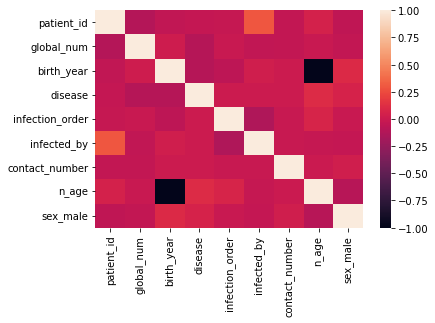

In [67]:
correlations = df.corr()
_ = sns.heatmap(correlations)

**<font color='teal'> Plot the boxplots to check for outliers. </font>**

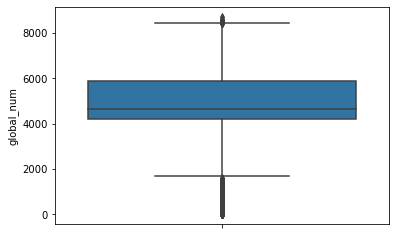

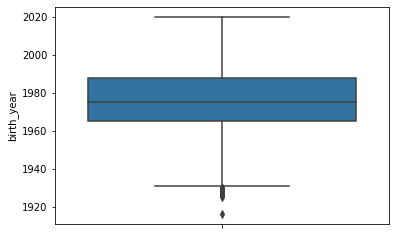

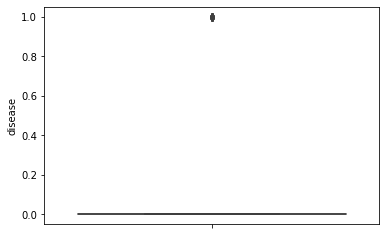

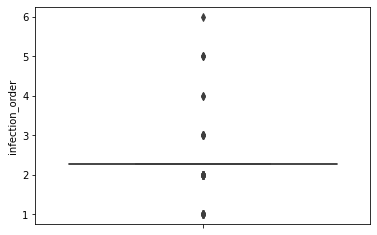

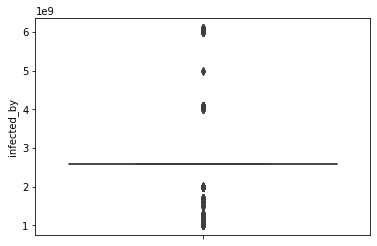

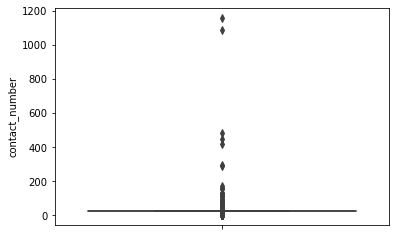

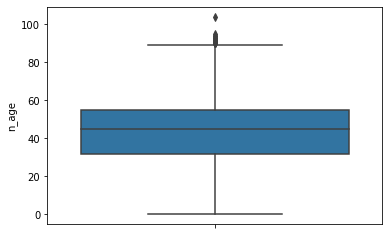

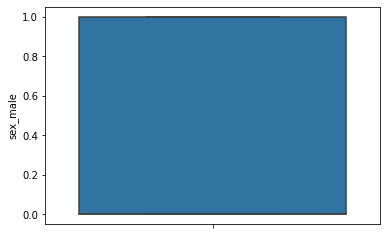

In [68]:
dfn = df.select_dtypes(include=['float64','int64'])
for column in dfn.drop('patient_id', axis=1).columns:
    _ = sns.boxplot(y=column, data=dfn)
    plt.show()

**<font color='teal'> Create dummy features for object type features. </font>**

In [69]:
X = df.drop('state', axis=1)
y = df['state']
X = pd.get_dummies(X)

### Split the data into test and train subsamples

In [70]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

### Scale data to prep for model creation

In [71]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [72]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [73]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.854
Random Forest: f1-score=0.822


### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [74]:
class_names=['isolated','released','missing','deceased'] # name  of classes

Confusion matrix, without normalization
[[  5   3   0]
 [  0 359   8]
 [  0  54  15]]
Normalized confusion matrix
[[0.62 0.38 0.  ]
 [0.   0.98 0.02]
 [0.   0.78 0.22]]


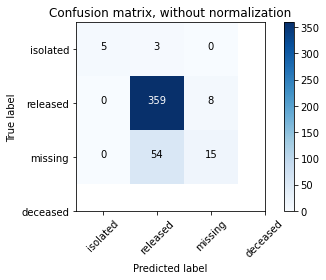

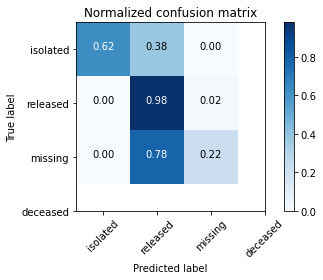

In [75]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

30


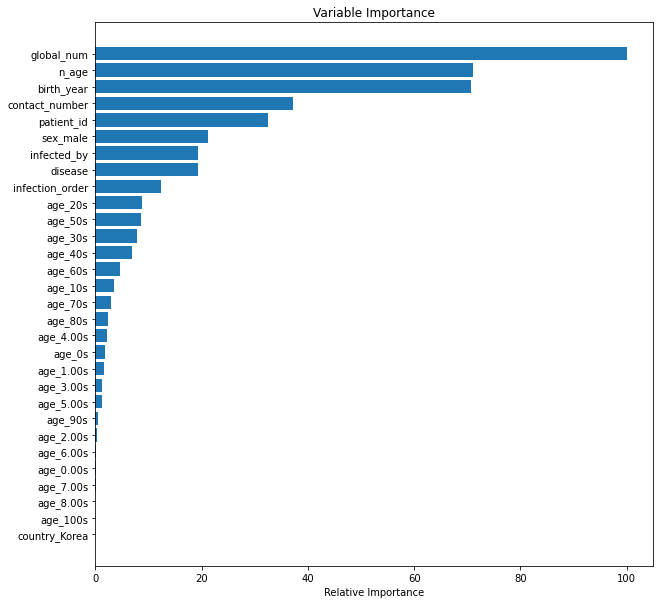

In [76]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.